<a href="https://colab.research.google.com/github/waqasisme/FestoCodingChallenge2022/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CodeFest 22 Solution Notebook**
[link to competition website](https://2022.coding-challenge.festo.com/)




# **Introduction**
https://2022.coding-challenge.festo.com/puzzle/0

In [9]:
import pandas as pd
df = pd.read_csv('office_database.csv', names= ["Username", "ID", "AccessKey", "FirstLoginTime"])
df.head()

,Username,ID,AccessKey,FirstLoginTime
0,immenseResearch,500025,211,08:04
1,great.night,648341,6,09:04
2,gray_basket,478873,82,07:15
3,bubblyPerson,294887,208,09:03
4,WorriedLine,489479,231,07:47


In [10]:
id_match = df['ID'].apply(lambda f: "814" in str(f)) # matching ID numbers
sum(id_match)

91

In [11]:
can_go_kitchen = df['AccessKey'].apply(lambda f: f & 8 != 0) # people with access to module 5
sum(can_go_kitchen)

93

In [12]:
from datetime import datetime
# cleaning up first login time column to trim strings and fix format
df['FirstLoginTime'] = df['FirstLoginTime'].apply(lambda f: f.strip())
df['FirstLoginTime'] = df['FirstLoginTime'].apply(lambda f: '12:12' if f == '99:99' else f)
df['FirstLoginTime'] = pd.to_datetime(df.FirstLoginTime, format='%H:%M')
# python turned them into full date time objects, in hindsight should've just used epoch 
could_be_there = df['FirstLoginTime'].apply(lambda d: d < datetime.strptime('1900-01-01 07:14:00', '%Y-%m-%d %H:%M:%S'))
sum(could_be_there)


86

## Introduction Solution

In [13]:
# people that meet each condition
df[id_match & can_go_kitchen & could_be_there] # answer to introduction (HQ)

,Username,ID,AccessKey,FirstLoginTime
4574,mystery_man,814217,26,1900-01-01 07:08:00


# **Episode 1** 
https://2022.coding-challenge.festo.com/puzzle/10

In [14]:
# our person class for easy mapping with a helper function for later (to determine picoBots in blood)
from typing import List
class Person:
  name: str
  id: int
  homePlanet: str
  bloodSample: List[str]

  def __init__(self, name, id, homePlanet, bloodSample):
    self.name = name
    self.id = id
    self.homePlanet = homePlanet
    self.bloodSample = bloodSample
    
  # checks blood sample and it's transpose for the word pico
  def hasPicoBots(self) -> bool:
    rotated_bloodSample = []
    for j in range(8):
      rotated_bloodSample.append("".join([self.bloodSample[i][j] for i in range(6)]))
    # print(rotated_bloodSample)
    return any(['pico' in line or 'ocip' in line for line in self.bloodSample]) \
    or any(['pico' in line or 'ocip' in line for line in rotated_bloodSample]) 
                                                                                       

In [15]:
# utility function to test different blood samples from clean and gen1 files
def arg_cleaner(arg):
  '''+--------+
  |    pico|
  | ppco ci|
  |op c    |
  |c c poco|
  |pcp  cpi|
  |ciccccoo|
  +--------+'''
  arg = [line.strip()[1:-1] for line in arg.split('\n')[1:-1]]
  return arg

clean = Person(None, None, None, arg_cleaner('''+--------+
  |    piio|
  | ppco ci|
  |op c    |
  |c c poco|
  |pcp  cpi|
  |ciccccoo|
  +--------+'''))
hasBots = Person(None, None, None, arg_cleaner('''+--------+
  |    pccc|
  | ppcp ci|
  |op ci   |
  |c c coco|
  |pcp ocpi|
  |ciccccoo|
  +--------+'''))
print(clean.hasPicoBots())
print(hasBots.hasPicoBots())


False
True


## **(1.1) Puzzle 1**

In [16]:
def read_population_data(fileName: str) -> List[Person]:
  population = []
  l = []
  with open(fileName, 'r') as file:
      l = file.readlines()

  # loop over data 14 lines at a time to clean it up and store as person objects
  for i in range(0, len(l), 14):
    person = l[i:i + 14]
    name = " ".join(person[0].split()[1:]) # skip 'Name: ' 
    id = int(person[1].split()[1]) # skip 'ID: '
    home = " ".join(person[2].split()[2:]) # skip 'home planet: '
    bs = [line.strip()[1:-1] for line in person[3:][2:8]] # read bloodSample as list of str, trimming whitespace removing | and +- lines (only storing chars)
    population.append(Person(name, id, home, bs))

  return population

In [17]:
# compile population dataset
population = read_population_data('population.txt')
print(len(population)) # check/verify size of pop with file


12732


In [18]:
sum([person.id for person in population if person.hasPicoBots()]) # answer to puzzle 1

2288948789

In [166]:
len([person.id for person in population if person.hasPicoBots()])

422

## **(1.2) Puzzle 2**

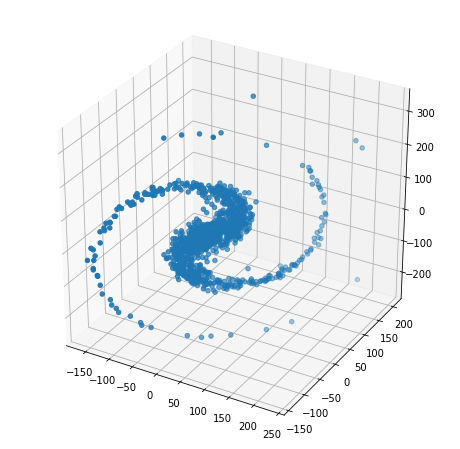

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# make a dict for galaxy_map with (name, coordinates)
galaxy_map = {}
x, y, z = [], [], []

with open('galaxy_map.txt') as glx:
  lines = [line.split(':') for line in glx.readlines()]
  for line in lines:
    planet = line[0].strip()
    coordinates = tuple(map(int, line[1].strip()[1:-1].split(',')))
    galaxy_map[planet] = coordinates 
    x.append(coordinates[0])
    y.append(coordinates[1])
    z.append(coordinates[2])

# plot galaxy to visualize outliers
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)
plt.show()

In [22]:
# ! pip install scikit-spatial
from skspatial.objects import Plane
from skspatial.objects import Points
from skspatial.plotting import plot_3d

# find best fitting plane for our coordinates
points = Points([list(v) for k, v in galaxy_map.items()])
plane = Plane.best_fit(points)
distances = dict([(k, plane.distance_point(list(v))) for k, v in galaxy_map.items()])
outliers = dict([(k, v) for k, v in distances.items() if v > 2]) # outlier limit specified in question
outliers

{'Algo Major': 17.094076994006272,
 'Alpha Andron': 18.570147347806227,
 'Alpha Aurnus': 15.30644512387339,
 'Alpha Carsa': 16.558030382638748,
 'Alpha Lupisci': 17.01317619023222,
 'Alpha Menax Minor': 14.679062809785268,
 'Andros Major': 18.15572354742764,
 'Aquarth': 17.330929522841473,
 'Beta Dela IV': 19.695138612851604,
 'Carda III': 15.722061712776394,
 'Cerenis V': 18.505882337039477,
 'Cralis III': 15.23428215897532,
 'Dralis II': 17.43018479591629,
 'Earia': 20.09897682279569,
 'Equila Minor': 17.092541439010297,
 'Erinix': 17.83350330363349,
 'Forale': 18.473352389560475,
 'Gamma Bores': 15.069918330075517,
 'Gamma Carinus Major': 17.048515571908123,
 'Minoces': 16.853352118091596,
 'Phoeni V': 17.54729203485332,
 'Pisci': 16.763092834422906,
 'Vens IV': 18.294465731222203,
 'Venta': 17.39189067372093,
 'Viria II': 19.426604266384306}

In [23]:
sum([person.id for person in population if person.homePlanet in outliers.keys()]) # answer to puzzle 2

2438905648

## **(1.3) Puzzle 3**

In [24]:
# sequence of places retrieved from Jelly Jones' fitbit watch
jelly_jones_sequence = ['Junkyard', 'Pod Racing Track', 'Pod Racing Track', 'Palace', 'Factory']

In [25]:
# read data from security_log
with open('security_log.txt', 'r') as file:
  lines = file.readlines()


# into a structure with { people: [places]} (places are inserted in order file order)

# convert 24hr to minute of day
def minute_of_day(time):
  hours, minutes = list(map(int, time.split(':')))
  return hours * 60 + minutes

people = {}
blacklist = set()
i = 0
while i < len(lines):
  line = lines[i]
  if 'Place' in line:
    last_place = line.split(':')[1].strip()
  elif 'in:' in line or 'out:' in line: # in/out list colon added to avoid names like 'edwin'
    last_people = line.split(':')[1].strip().split(', ')  
    for person in last_people:
      if person not in people:
        people[person] = {}
      people[person][last_time] = last_place

      # we are interested in people only if they visited JUST the places from jelly_jones_sequence
      if last_place not in jelly_jones_sequence:
        blacklist.add(person)
  elif ':' in line: # time
    last_time = minute_of_day(line.strip())
  i += 1

len(people)

12732

In [169]:
# people who only visited the places we want
person_of_interest = [person for person in people if person not in blacklist]

# next we go over the given places and determine people who visited them in the desired entry-exit sequence
target_sequence = []
for item in zip(jelly_jones_sequence, jelly_jones_sequence): # generate entry exit sequence for fitness tracker 
  target_sequence.append(item[0])
  target_sequence.append(item[1])

# peoples visits ordered (by time) for Monday
routines = {}
for person in person_of_interest:
  routines[person] = [item[1] for item in sorted(people[person].items())] # ordered by entry and exit times

# people whose visit sequence and frequency matches with desired sequence
populationWithMatchingRoutines = [person for person in routines if routines[person] == target_sequence]
len(populationWithMatchingRoutines)

607

In [170]:
sum([person.id for person in population if person.name in populationWithMatchingRoutines]) # answer to puzzle 3

3362264068

## Episode 1 Solution

In [167]:
[person.name for person in population \
 if person.hasPicoBots() and \
 person.homePlanet in outliers.keys() and \
 person.name in populationWithMatchingRoutines]

['Tun Kazem']

# **Episode 2** 

https://2022.coding-challenge.festo.com/puzzle/20

In [29]:

# compile population dataset using our previously defined function
population = read_population_data('population.txt')

print(len(population)) # check/verify size of pop with file

12732


## **(2.1) Puzzle 1**

In [30]:
# now we add a function to our person class to detect gen2 picobots
def hasGen2PicoBots(self) -> bool:
  # we can only go up, down, left, right, while respecting edges
  get_neighbors = lambda i, j: [n for n in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)] if n[0] >= 0 and n[0] < 6 and n[1] >= 0 and n[1] < 8] 
  
  # recursive solution checking for remaining 'picoico' string in neighbors
  def hasGen2PicoBotsHelper(bloodSample, i, j, target_string) -> bool:
    if len(target_string) == 0: # found complete chain
      return True

    if bloodSample[i][j] != target_string[0]: # current target letter not found chain is broken
      return False
    neighbors = get_neighbors(i, j) # [(n[0], n[1])]
    return any([hasGen2PicoBotsHelper(bloodSample, n[0], n[1], target_string[1:]) for n in neighbors])


  for i in range(len(self.bloodSample)):
    for j in range(len(self.bloodSample[i])):
      if hasGen2PicoBotsHelper(self.bloodSample, i, j, 'picoico'):
        return True

  return False
        

Person.hasGen2PicoBots = hasGen2PicoBots

In [31]:
# check if our function is working by taking data from clean/infected datasets and verifying for all
def run_gen2_blood_test(files) -> bool:
  clean = files[0]
  dirty = files[1]
  
  with open(clean, 'r') as clean_file:
    lines = clean_file.readlines()

  clean_samples = []
  for i in range(0, len(lines), 11):
      clean_samples.append(arg_cleaner("".join(lines[i+1:i+11]).strip()))
  all_clean = not any([Person(None, None, None, sample).hasGen2PicoBots() for sample in clean_samples])
  
  with open(dirty, 'r') as dirty_file:
    lines = dirty_file.readlines()

  dirty_samples = []
  for i in range(0, len(lines), 11):
      dirty_samples.append(arg_cleaner("".join(lines[i+1:i+11]).strip()))
  all_dirty = all([Person(None, None, None, sample).hasGen2PicoBots() for sample in dirty_samples])
  return all_clean and all_dirty


# 1st file should be all false on function, 2nd all true
run_gen2_blood_test(['lab_blood_clean.txt', 'lab_blood_gen2.txt']) 

True

In [32]:
populationWithGen2PicoBots = [person for person in population if person.hasGen2PicoBots()]
sum([person.id for person in populationWithGen2PicoBots]) # answer to puzzle 1

2105304392

In [33]:
len(populationWithGen2PicoBots)

393

## **(2.2) Puzzle 2**

In [151]:
# make a dict for galaxy_map with (name, coordinates)

galaxy_map = {}
x, y, z = [], [], []

with open('galaxy_map.txt') as glx:
  lines = [line.split(':') for line in glx.readlines()]
  for line in lines:
    planet = line[0].strip()
    coordinates = tuple(map(int, line[1].strip()[1:-1].split(',')))
    galaxy_map[planet] = coordinates

In [152]:
print(len(galaxy_map.keys())) # verify we have all planets

1046


In [147]:
# read trade route data, only consider trade routes that are marked as Ok
trade_routes = []

with open('trade_routes.txt', 'r') as tr: 
  lines = tr.readlines()
  for line in lines:
    if 'Ok' in line:
      planets = line.split(':')[0]
      planets = tuple(map(lambda p: p.strip(), planets.strip().split('-')))
      trade_routes.append((planets[0], planets[1]))
trade_routes

[('Scurus V', 'Tauries VII'), ('Beta Drado VI', 'Uranis')]

In [153]:
import numpy as np
import math

# helper function to find distance between point and segment
def lineseg_dist(p, a, b):
    d = np.divide(b - a, np.linalg.norm(b - a))
    s = np.dot(a - p, d)
    t = np.dot(p - b, d)
    h = np.maximum.reduce([s, t, 0])
    c = np.cross(p - a, d)
    return np.hypot(h, np.linalg.norm(c))

planetsCloseToTradeRoutes = set()
for planet in galaxy_map:
  distances_to_routes = []
  for route in trade_routes:
    # check nearest distance of this planet to trade route between planets a and b
    p = np.asarray(galaxy_map[planet]) 
    a = np.asarray(galaxy_map[route[0]])
    b = np.asarray(galaxy_map[route[1]])
    distances_to_routes.append(lineseg_dist(p, a, b))
  if all([d <= 10 for d in distances_to_routes]): # if this planet is close to all the Ok trade routes
    planetsCloseToTradeRoutes.add(planet)
print(len(planetsCloseToTradeRoutes))
planetsCloseToTradeRoutes

19


{'Alpha Algolum V',
 'Alpha Aurus',
 'Alpha Cena',
 'Antlis VI',
 'Arius IV',
 'Beta Pupis',
 'Cane IV',
 'Cephina',
 'Cetices',
 'Charida',
 'Crales',
 'Deleo',
 'Gamma Cani VII',
 'Gemina',
 'Orius V',
 'Perpis',
 'Scurus V',
 'Venis',
 'Vulutor'}

In [159]:
populationCloseToTradeRoutes = [person for person in population if person.homePlanet in planetsCloseToTradeRoutes]
sum([person.id for person in populationCloseToTradeRoutes]) # answer to puzzle 2

966181533

In [160]:
len(populationCloseToTradeRoutes)

167

## **(2.3) Puzzle 3**

In [310]:
# we need to check how long every person stayed at a location on Monday from the security log
# every stay at a location can be either free time or work time (number_of_minutes = amount_earned)

target_salary = 79 # from the question

# read data from security_log
with open('security_log.txt', 'r') as file:
  lines = file.readlines()


# put into a structure with { people: { duration_at_a_place, ... } } 
# for the same place, a person has to first enter and then exit the location, taking the difference between both those times
# we get the duration for that location, the type of place does not matter as salary is the same everywhere
# so we can discard the place label and keep only a list of durations

people = {}
i = 0
while i < len(lines):
  line = lines[i]

  if 'Place' in line:
    last_place = line.split(':')[1].strip()
  elif 'in:' in line or 'out:' in line: # in/out list, colon added to avoid names like 'edwin'
    last_people = line.split(':')[1].strip().split(', ')  
    for person in last_people:
      if person not in people: # person entering this place for the first time
        people[person] = [(last_time, )]
        # person exiting this place
      elif len(people[person][-1]) == 1:  # odd means last index has an entry time, add exit time
        people[person][-1] = (people[person][-1][0], last_time)
      else: # even, last index is full with entry and exist, add new entry time  
        people[person].append((last_time, )) # update last position in list

  elif ':' in line: # time
    last_time = minute_of_day(line.strip())
  i += 1
len(people)

12732

In [311]:
people['Shakuntala Lee'] # verify location duration history is correct with file

[(338, 361), (978, 1026), (400, 450), (675, 808)]

In [318]:
# now that we have information about how long everyone stayed at a place on Monday we can get work on the durations
# we simply find a possible subset of the durations for a person that sums up to 79
# if such a subset exists they could have earned 79 GAL on Monday.


# NOTE: this is the subset sum problem (https://en.wikipedia.org/wiki/Subset_sum_problem) and can be solved using DP
# however since there are only a max of 12 locations, if a person visited all of them that would have 2^12 possible subsets
# which is tractable with brute force
# for the DP solution see: https://www.geeksforgeeks.org/python-program-for-subset-sum-problem-dp-25/

from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


# first we get only the numeric durations for every person's day
# then generate powerset of those durations
# checking the sum for each subset
# at the first sum that matches the target, we stop
populationWithPossibleEarning = set()
for person in people: # in order to optimize subset calculation we get rid of durations which cannot contribute to the answer
  durations = [n for n in [b - a for a, b in people[person]] if n <= target_salary]
  if any([sum(subset) == target_salary for subset in powerset(durations)]):
    populationWithPossibleEarning.add(person)
  

len(populationWithPossibleEarning)

601

In [325]:
sum([person.id for person in population if person.name in populationWithPossibleEarning]) # answer to puzzle 3

3288804647

## Episode 2 Solution

In [324]:
[person.name for person in populationCloseToTradeRoutes if person.hasGen2PicoBots() and person.name in populationWithPossibleEarning]

['Jianwei Yakubu']